# **BasketBall Playoffs**

#### We start by importing everything we need for the project

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
from sklearn.linear_model import LinearRegression


## Data Processing

---

### CSV reading

Now we need to transform all of the CSV's into dataframes so that they can be hadled by our code

In [30]:
awards_players_df = pd.read_csv("data/awards_players.csv")
coaches_df = pd.read_csv("data/coaches.csv")
players_teams_df = pd.read_csv("data/players_teams.csv")
players_df = pd.read_csv("data/players.csv")
series_post_df = pd.read_csv("data/series_post.csv")
teams_post_df = pd.read_csv("data/teams_post.csv")
teams_df = pd.read_csv("data/teams.csv")

--- 

### Dropping some columns and rows

We dropped the following data:
- Rows
    - Some invalid player entries were found with null values in every column. They were filtered based on the birthDate
- Columns
    - "lgID" was dropped in every dataframe it was found, since its value is **always** the same
    - "lgIDWinner" and "lgIDLoser", same issue as above
    - "seeded","arena","franchID","name","divID" were dropped from the teams dataframe since we considered that those values were irrelevant for the predicitons


In [31]:
# first season can be used to calculate "experience"
players_df = players_df.drop(["deathDate","firstseason","lastseason"], axis="columns")
awards_players_df = awards_players_df.drop(["lgID"], axis="columns")
coaches_df = coaches_df.drop(["lgID"], axis="columns")
players_teams_df = players_teams_df.drop(["lgID"], axis="columns")
series_post_df = series_post_df.drop(["lgIDWinner","lgIDLoser"], axis="columns")
teams_post_df = teams_post_df.drop(["lgID"], axis="columns")
teams_df = teams_df.drop(["lgID","seeded","arena","franchID","name","divID"], axis="columns")
players_df = players_df[players_df['birthDate'] != '0000-00-00']
players_df = players_df.rename(columns={"bioID": "playerID"})


---

### Merging DataFrames

Now we merged all the daframes, excluding the post season ones. We consisedered that that data wouldn't be relevant for the predictions

In [32]:
merged_df = pd.merge(players_teams_df, players_df, how="left", on=["playerID"])
merged_df = pd.merge(merged_df, awards_players_df, how="left", on=["playerID","year"])
teams_merged_df = pd.merge(teams_df, coaches_df, how="left", on=["year","tmID"])
merged_df = pd.merge(merged_df, teams_merged_df, how="left", on=["year","tmID"])        



---

### Handling NaN values

Now we need to check if we have any columns where rows with "NaN" values exist

In [33]:
nan_counts = merged_df.isnull().sum()
nan_columns = nan_counts[nan_counts > 0]

print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
college          229
collegeOther    2141
award           2070
firstRound       997
semis           1613
finals          1901
dtype: int64


6 of our columns possess NaN values, so, we will replace those values with "None"

In [34]:

merged_df["college"] = merged_df["college"].fillna("None")
merged_df["collegeOther"] = merged_df["collegeOther"].fillna("None")
merged_df["award"] = merged_df["award"].fillna("None")
merged_df["firstRound"] = merged_df["firstRound"].fillna("None")
merged_df["semis"] = merged_df["semis"].fillna("None")
merged_df["finals"] = merged_df["finals"].fillna("None")    

---

### Handling non numerical values

First, lets see which of our columns have non numeric values:

In [35]:
non_numeric_columns = merged_df.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numeric columns:")
print(non_numeric_columns)

Non-numeric columns:
['playerID', 'tmID', 'pos', 'college', 'collegeOther', 'birthDate', 'award', 'confID', 'playoff', 'firstRound', 'semis', 'finals', 'coachID']


Our model can only take numerical values, therefore, we need to encode these columns into ids.

We will start by our target variable and then do the rest:

In [36]:
encoder = LabelEncoder()
merged_df["playoff"] = encoder.fit_transform(merged_df["playoff"])

# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

N: 0
Y: 1


In [37]:
merged_df["firstRound"] = encoder.fit_transform(merged_df["firstRound"])
# print what was mapped to what
print()
print("firstRound:")
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

merged_df["semis"] = encoder.fit_transform(merged_df["semis"])
print()
print("semis:")
# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

merged_df["finals"] = encoder.fit_transform(merged_df["finals"])
print()
print("finals:")
# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

merged_df["pos"] = encoder.fit_transform(merged_df["pos"])
print()
print("pos:")
# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

merged_df["confID"] = encoder.fit_transform(merged_df["confID"])
print()
print("confID:")
# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")


firstRound:
L: 0
None: 1
W: 2

semis:
L: 0
None: 1
W: 2

finals:
L: 0
None: 1
W: 2

pos:
C: 0
C-F: 1
F: 2
F-C: 3
F-G: 4
G: 5
G-F: 6

confID:
EA: 0
WE: 1


For the college and collegeOther columns, we had to take some special measures to ensure id consistency. We create a dictionary during the college column encoding, add some missing colleges and reuse it to encode the collegeOther column.

In [38]:
merged_df["college"] = encoder.fit_transform(merged_df["college"])

college_normalization_rules = {}

# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    # save these values to a dictionary
    college_normalization_rules[label] = idx
    print(f"{label}: {college_normalization_rules[label]}")

Academy of Sport Moscow: 0
Alabama: 1
Alabama-Birmingham: 2
Arizona: 3
Arizona State: 4
Arkansas: 5
Arkansas State: 6
Auburn: 7
Australian Institute of Sport: 8
Baylor: 9
Boise State: 10
Boston College: 11
Brigham Young: 12
California: 13
Central Florida: 14
Cincinnati: 15
Clemson: 16
Colorado: 17
Colorado State: 18
Connecticut: 19
DePaul: 20
Delaware: 21
Denver: 22
Duke: 23
Duquesne: 24
Flordia: 25
Florida: 26
Florida Atlantic: 27
Florida International: 28
Florida State: 29
Furman: 30
George Mason: 31
George Washington: 32
Georgetown: 33
Georgia: 34
Georgia Tech: 35
Harvard: 36
Hawai'i: 37
Houston: 38
Howard: 39
Illinois: 40
Illinois State: 41
Indiana: 42
Iona: 43
Iowa: 44
Iowa State: 45
James Madison: 46
Kansas: 47
Kansas State: 48
Kentucky: 49
Liberty: 50
Long Beach State: 51
Louisiana State: 52
Louisiana Tech: 53
Louisville: 54
Maine: 55
Maryland: 56
Memphis: 57
Miami (FL): 58
Michigan: 59
Michigan State: 60
Middle Tennessee State: 61
Minnesota: 62
Mississippi: 63
Mississippi State

In [39]:
college_normalization_rules["NE Oklahoma A&M (JC)"] = 126
college_normalization_rules["Arkansas-Fort Smith (fr-so)"] = 127
college_normalization_rules["Grayson County (JC)"] = 128

def normalize_collegeOther(name):
    return college_normalization_rules[name]

merged_df["collegeO"] = merged_df["collegeOther"].apply(normalize_collegeOther)
merged_df = merged_df.drop(["collegeOther"], axis="columns")

In the awards column, we also had to take some special measures since some awards had different names, despite being the same award

In [40]:
def normalize_awards(award):
    normalization_rules = {
        "None": 0,
        "All-Star Game Most Valuable Player": 1,
        "Coach of the Year": 2,
        "Defensive Player of the Year": 3,
        "Kim Perrot Sportsmanship": 4,
        "Kim Perrot Sportsmanship Award": 4,
        "Most Improved Player":5,
        "Most Valuable Player":6,
        "Rookie of the Year":7,
        "Sixth Woman of the Year":8,
        "WNBA Finals Most Valuable Player":9,
        "WNBA All-Decade Team":10,
        "WNBA All Decade Team Honorable Mention":11
    }
    return normalization_rules[award]

merged_df["normalized_award"] = merged_df["award"].apply(normalize_awards)
merged_df = merged_df.drop(["award"], axis="columns")


We decided it was important to calculate each of the players age, since it my be relevant for the calculations

In [41]:

def calculate_age(merged_df):

    if not pd.api.types.is_datetime64_dtype(merged_df['birthDate']):
        merged_df['birthDate'] = pd.to_datetime(merged_df['birthDate'])
    
    merged_df['age'] = 2014 + merged_df['year'] - merged_df['birthDate'].dt.year
    

    merged_df.drop(columns=['birthDate'],inplace=True)

    return merged_df
    
calculate_age(merged_df)
merged_df
    

,playerID,year,stint_x,tmID,GP_x,GS,minutes,points,oRebounds,dRebounds,...,attend,coachID,stint_y,won_y,lost_y,post_wins,post_losses,collegeO,normalized_award,age
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,120607,aglerbr99w,0,12,20,0,0,70,0,36
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,139874,aglerbr99w,1,6,13,0,0,70,0,37
2,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,139874,vandehe99w,2,4,9,0,0,70,0,37
3,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,120253,mcconsu01w,0,18,16,1,2,70,0,38
4,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,125097,mcconsu01w,0,18,16,0,2,70,0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,zarafr01w,6,0,SEA,34,4,413,90,11,28,...,151150,donovan99w,0,20,14,1,2,70,0,44
2156,zellosh01w,10,0,DET,34,4,802,406,25,81,...,136069,laimbbi01w,1,1,2,0,0,70,0,38
2157,zellosh01w,10,0,DET,34,4,802,406,25,81,...,136069,mahorri01w,2,17,14,3,2,70,0,38
2158,zirkozu01w,4,0,WAS,6,0,30,11,0,2,...,238710,stanlma99w,0,9,25,0,0,70,0,38


---

## Data Analysis

Let's print some graphs to analyse how our data is destributed:

In [42]:
# plt.figure(figsize=(25,25))
# plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

# merged_df1 = merged_df[merged_df['playoff']==1].drop(['playoff'],axis=1)
# merged_df2 = merged_df[merged_df['playoff']==0].drop(['playoff'],axis=1)

# cols = list(merged_df1.columns)

# for i, col in enumerate(cols):
#     plt.subplot(11,11,i+1)
#     sb.histplot(data=merged_df1[col], color='red', label = 'Y', kde=True)
#     sb.histplot(data=merged_df2[col], color='blue', label = 'N', kde=True)
#     _,axes = plt.gca().get_legend_handles_labels()
#     plt.legend(axes,prop={'size': 10})

# plt.show()

---
## Our Model

### The SVM Model

The prediction_year needs to be set to the year we want to predict the results

In [43]:
prediction_year = 6

# train and test data split
train_data = merged_df[merged_df['year'] < prediction_year]
nextyear_df = merged_df[merged_df['year'] == prediction_year]

# remove the identification columns from the train data
X_train = train_data.drop(columns=['playoff', 'year', 'playerID', 'tmID', 'coachID'])
# select the target column for the train data
y_train = train_data['playoff']

# create the SVC model and setting it to output probabilities
svm_model = SVC(probability=True)
# run the model on the train data
svm_model.fit(X_train, y_train)

# remove the identification columns from the test data
X_test = nextyear_df.drop(columns=['playoff', 'year', 'playerID', 'tmID', 'coachID'])

# get probabilities column from the model
predicted_probabilities = svm_model.predict_proba(X_test)[:, 1]
# get predictions from the model
predictions = svm_model.predict(X_test)

# create a new dataframe with the identification columns and the probabilities
results_df = nextyear_df[['year', 'playerID', 'tmID', 'coachID']].copy()
results_df['predicted_probability'] = predicted_probabilities

# create a sorted dataframe where the most likely players to go to playoffs are on the top
sorted_df = results_df.sort_values(by='predicted_probability', ascending=False)
# and print it
sorted_df


,year,playerID,tmID,coachID,predicted_probability
694,6,hammobe01w,NYL,coylepa99w,0.647463
923,6,johnsvi01w,NYL,coylepa99w,0.647361
87,6,baranel01w,NYL,coylepa99w,0.647324
1582,6,robincr01w,NYL,coylepa99w,0.647285
2001,6,wautean01w,NYL,coylepa99w,0.647281
...,...,...,...,...,...
1154,6,matteca01w,CHA,laceytr99w,0.354490
1288,6,mooreje01w,CHA,boguemu01w,0.354489
1289,6,mooreje01w,CHA,laceytr99w,0.354488
1537,6,rasmukr01w,CHA,boguemu01w,0.354482


#### Model Evaluation
Here we will output the following statistics:
- accuracy
- precision
- recall
- f1
- roc auc

In [44]:

y_test = nextyear_df['playoff']

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predicted_probabilities)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8086124401913876
Precision: 0.8796296296296297
Recall: 0.7786885245901639
F1 Score: 0.8260869565217391
ROC AUC Score: 0.800263802524967


Now the confusion matrix:

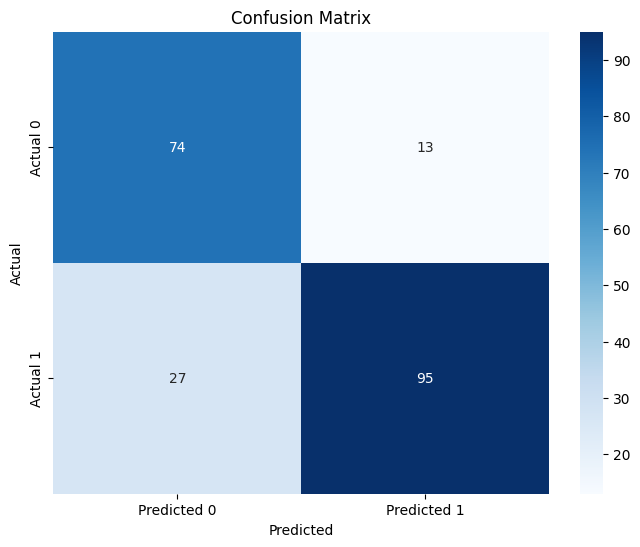

In [45]:
conf_matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix using Seaborn for a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [46]:
report = classification_report(y_test, predictions, target_names=["Class 0", "Class 1"])
print(report)

              precision    recall  f1-score   support

     Class 0       0.73      0.85      0.79        87
     Class 1       0.88      0.78      0.83       122

    accuracy                           0.81       209
   macro avg       0.81      0.81      0.81       209
weighted avg       0.82      0.81      0.81       209



---
## The Prediction function:
This function takes as input an array of 5 playerID's and calculates that teams chance of going into playoffs:

In [84]:
def get_team_playoff_probability(player_array, predictions):
    print(predictions)
    total_sum_probability = 0.0
    if len(player_array) != 5:
        print("The input team does not have the correct player amount")
        return 0.0

    for player in player_array:
        predicted_probability = results_df.loc[results_df['playerID'] == player, 'predicted_probability'].values
        if len(predicted_probability) > 0:
            # Found data for the player
            if len(predicted_probability) > 1:
                print("Multiple players with id: ", player)
                total_sum_probability += predicted_probability[0]
            else:
                total_sum_probability += predicted_probability[0]
        else:
            # No data for the player: use prediction from the output of `plot_and_predict_all_rookie_evolutions`
            print(f"No data for player ID {player}. Using predicted rookie average probability.")
            print(predictions.get('predicted_probabilities', 0.0))
            total_sum_probability += predictions.get('predicted_probability', 0.0)

    actual_probability = total_sum_probability / 5
    return actual_probability


In [85]:
import pandas as pd

def get_rookie_averages(year, players_teams_df):
    averages_dict = {}

    # Iterate over each year to calculate rookie averages
    for y in range(1, year + 1):
        # Get the players for the current and previous year
        current_year_players = players_teams_df[players_teams_df['year'] == y]['playerID']
        previous_year_players = players_teams_df[players_teams_df['year'] == y - 1]['playerID']
        
        # Determine rookies
        rookies = set(current_year_players) - set(previous_year_players)
        
        # Filter to get only rookie data
        rookies_df = players_teams_df[
            (players_teams_df['year'] == y) & (players_teams_df['playerID'].isin(rookies))
        ]
        
        if not rookies_df.empty:
            numeric_cols = rookies_df.select_dtypes(include='number').columns
            averages = rookies_df[numeric_cols].mean()
        else:
            # Handle years with no rookies
            averages = pd.Series(dtype=float)
        
        # Store the averages in the dictionary
        averages_dict[y] = averages

    # Convert dictionary to DataFrame
    averages_df = pd.DataFrame(averages_dict).transpose()
    
    return averages_df

def plot_and_predict_all_rookie_evolutions(averages_df):
    # Initialize a dictionary to store predictions
    predictions = {}

    # Iterate through all numeric columns
    numeric_columns = averages_df.select_dtypes(include='number').columns
    # Drop the 'year' column from numeric_columns if it exists
    numeric_columns = numeric_columns.drop('year', errors='ignore')
    for stat_column in numeric_columns:
        # Extract years and values
        years = averages_df.index.values.astype(int)
        values = averages_df[stat_column].values

        # Prepare data for linear regression
        X = years.reshape(-1, 1)  # Predictor (Year)
        y = values                # Target (Stat column values)

        # Train a linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Predict the average value for the next year
        next_year = years[-1] + 1
        predicted_value = model.predict([[next_year]])[0]

        # Store the prediction
        predictions[stat_column] = predicted_value

    return predictions



In [86]:
team = ["hammobe01w","matteca01w","rasmukr01w","johnsvi01w","robir01w"]
players_teams_df = pd.read_csv("data/players_teams.csv")
rookie_averages_df = get_rookie_averages(5, players_teams_df)
predictions = plot_and_predict_all_rookie_evolutions(rookie_averages_df)
print(predictions)
team_probability = get_team_playoff_probability(team, predictions)

print(team_probability)

{'stint': 0.06340266875981163, 'GP': 18.746527109603146, 'GS': 1.3836188197363306, 'minutes': 208.37700937695166, 'points': 57.37177039550309, 'oRebounds': 10.534450591651048, 'dRebounds': 22.346319272125722, 'rebounds': 32.88076986377678, 'assists': 13.80178909032595, 'steals': 6.791057713407941, 'blocks': 4.510933728330041, 'turnovers': 15.000191168278722, 'PF': 21.563753776945017, 'fgAttempted': 54.20891401225501, 'fgMade': 20.214259760976347, 'ftAttempted': 16.460292069681465, 'ftMade': 11.536712327610942, 'threeAttempted': 17.146891299944297, 'threeMade': 5.406538545939468, 'dq': 0.0016099491905943175, 'PostGP': 1.3576370250333385, 'PostGS': 0.20443463986090704, 'PostMinutes': 16.567220337266424, 'PostPoints': 4.80422216032815, 'PostoRebounds': 0.9545395081109365, 'PostdRebounds': 2.000209525497544, 'PostRebounds': 2.9547490336084805, 'PostAssists': 1.670039752873854, 'PostSteals': 0.408016407555578, 'PostBlocks': 0.3900879458483145, 'PostTurnovers': 1.1897115173612869, 'PostPF': 